# Projet ISI5

Auteur : **Tanguy Hardion**

Niveau : **ISI4 - VDC**

Semestre : **P24**

## Présentation

### Objectif

L'objectif de ce projet est d'entraîner un modèle pour classifier des images. Nous allons créer le modèle et l'entraîner de **zéro**, à partir d'un jeu de données d'images que nous allons pré-traiter.

### Méthode employée

Nous allons faire du **deep learning** supervisé et créer un **réseau de neurones convolutif** (CNN) pour entraîner notre modèle. Nous utiliserons la librairie `tensorflow`.

### Jeu de données

Il existe de nombreux datasets d'images labellisées. Pour ce projet, j'ai choisi le dataset **CIFAR-100**. Il s'agit d'un dataset de 60000 images couleur de 32x32 pixels, labellisées de deux manières :

- **Coarse labels** : 20 classes (catégories globales)
- **Fine labels** : 100 classes (sous-catégories)

Pour ce projet, nous allons utiliser les **fine labels** car ils permettent une classification plus précise, et donc un exercice de deep learning plus intéressant.

CIFAR-100 est divisé en 50000 images pour l'entraînement et 10000 pour le test. Le dataset est disponible sur [HuggingFace](https://huggingface.co/datasets/uoft-cs/cifar100), et sera donc l'endroit où nous le récupérerons. Tous les labels sont des entiers, et les noms des classes sont disponibles sur HuggingFace ou plus loin dans ce notebook (dans la variable `fine_labels_dict`, utilisée pour lors du test).

### Contenu du projet

- Ce fichier `.ipynb` contenant encore les sorties des cellules de code de ma dernière exécution pour plus de clarté
- Un fichier `requirements.txt` spécifiant les packages nécessaires
- Un fichier `cifar100_model.keras` contenant le modèle entraîné (si vous ne souhaitez pas l'entraîner vous-même)

## Remarques

### Versions

Version de Python utilisée : `3.11.9`. En version `3.12`, des problèmes peuvent surgir avec TensorFlow.

Version de TensorFlow utilisée : `2.16.1`. À noter que si vous n'utilisez pas cette version de TensorFlow, il est possible que le modèle mis à disposition ne puisse pas être chargé.

Tous les packages nécessaires sont listés dans le fichier `requirements.txt`. Pour les installer, vous pouvez utiliser la commande suivante :

```bash
pip install -r requirements.txt
```

### Entraînement

L'entraînement peut prendre un certain temps, en fonction de la puissance de votre machine. Pour accélérer le processus, vous pouvez réduire le nombre d'epochs, ou bien utiliser un processeur plus puissant. Google Colab met à disposition gratuitement des GPU assez puissants pour ce genre de tâches. Vous trouverez donc ici une copie du notebook sur Colab : https://colab.research.google.com/drive/1ThgjorYnq74L_bifooxA8k3lEXtS0oge?usp=sharing

## Imports de librairies

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import random

## Chargement du dataset depuis HuggingFace

In [2]:
# Partie train : 50 000 images
train_dataset = load_dataset("cifar100", split="train")

# Partie test : 10 000 images
test_dataset = load_dataset("cifar100", split="test")

## Initialisation de variables utiles

In [3]:
# Nombre de classes ("fine_label") : 100
num_classes = len(train_dataset.features["fine_label"].names)
print(f"Nombre de classes : {num_classes}")

# Taille des images : 32x32 pixels avec 3 canaux de couleur (RGB)
image_shape = np.array(train_dataset[0]["img"]).shape
print(f"Taille des images : {image_shape}")

Nombre de classes : 100
Taille des images : (32, 32, 3)


In [4]:
# Dictionnaire des labels (copié de HuggingFace)
fine_labels_dict = {
    0: "apple",
    1: "aquarium_fish",
    2: "baby",
    3: "bear",
    4: "beaver",
    5: "bed",
    6: "bee",
    7: "beetle",
    8: "bicycle",
    9: "bottle",
    10: "bowl",
    11: "boy",
    12: "bridge",
    13: "bus",
    14: "butterfly",
    15: "camel",
    16: "can",
    17: "castle",
    18: "caterpillar",
    19: "cattle",
    20: "chair",
    21: "chimpanzee",
    22: "clock",
    23: "cloud",
    24: "cockroach",
    25: "couch",
    26: "cra",
    27: "crocodile",
    28: "cup",
    29: "dinosaur",
    30: "dolphin",
    31: "elephant",
    32: "flatfish",
    33: "forest",
    34: "fox",
    35: "girl",
    36: "hamster",
    37: "house",
    38: "kangaroo",
    39: "keyboard",
    40: "lamp",
    41: "lawn_mower",
    42: "leopard",
    43: "lion",
    44: "lizard",
    45: "lobster",
    46: "man",
    47: "maple_tree",
    48: "motorcycle",
    49: "mountain",
    50: "mouse",
    51: "mushroom",
    52: "oak_tree",
    53: "orange",
    54: "orchid",
    55: "otter",
    56: "palm_tree",
    57: "pear",
    58: "pickup_truck",
    59: "pine_tree",
    60: "plain",
    61: "plate",
    62: "poppy",
    63: "porcupine",
    64: "possum",
    65: "rabbit",
    66: "raccoon",
    67: "ray",
    68: "road",
    69: "rocket",
    70: "rose",
    71: "sea",
    72: "seal",
    73: "shark",
    74: "shrew",
    75: "skunk",
    76: "skyscraper",
    77: "snail",
    78: "snake",
    79: "spider",
    80: "squirrel",
    81: "streetcar",
    82: "sunflower",
    83: "sweet_pepper",
    84: "table",
    85: "tank",
    86: "telephone",
    87: "television",
    88: "tiger",
    89: "tractor",
    90: "train",
    91: "trout",
    92: "tulip",
    93: "turtle",
    94: "wardrobe",
    95: "whale",
    96: "willow_tree",
    97: "wolf",
    98: "woman",
    99: "worm",
}

## Exploration rapide du dataset

In [5]:
print("Forme du dataset : ", train_dataset.shape)

Forme du dataset :  (50000, 3)


### Affichage de quelques images aléatoires avec leur label

Comme les images sont en 32x32 pixels, elles sont assez petites, ce qui explique la basse résolution sur les images ci-dessous. Cependant, cela suffira amplement pour entraîner notre modèle de deep learning.

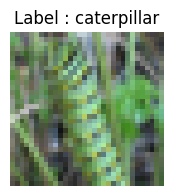

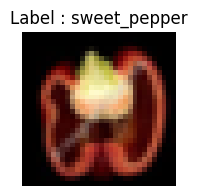

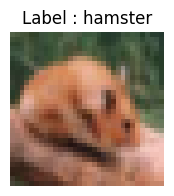

In [6]:
for i in range(3):
    random_index = random.randint(0, len(train_dataset))
    random_image = train_dataset[random_index]["img"]
    random_label = train_dataset[random_index]["fine_label"]
    plt.figure(figsize=(2, 2))
    plt.title(f"Label : {fine_labels_dict[random_label]}")
    plt.axis("off")
    plt.imshow(random_image)

## Pré-traitement des images

Nous allons maintenant pré-traiter les images pour les rendre exploitables par notre modèle de deep learning. Les images sont déjà normalisées (valeurs des pixels entre 0 et 1), mais nous allons :

- Les convertir en `tf.float32` pour pouvoir s'en servir avec TensorFlow
- Les redimensionner avec la fonction `resize` pour s'assurer qu'elles sont bien en 32x32 pixels.

### Fonction de pré-traitement

In [7]:
def preprocess_image(image, label):
    """
    Fonction de prétraitement des images.
    Convertit l'image en tf.float32 puis la redimensionne en 32x32 pixels.
    """

    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [32, 32])

    return image, label

### Fonction génératrice de données

En Python, un générateur est une fonction qui permet de charger les données en mémoire au fur et à mesure de l'entraînement, ce qui permet de ne pas surcharger la mémoire vive et de pouvoir entraîner des modèles sur des datasets très volumineux.

In [8]:
def generator(dataset):
    """
    Générateur d'images et de labels.
    À partir du dataset passé en paramètre, renvoie un tuple (image, label).

    L'image est d'abord convertie en array numpy et si elle est en 2D (niveaux de gris),
    elle est dupliquée sur 3 canaux pour que toutes les images soient de la même forme.
    """

    for element in dataset:
        # Récupération de l'image et du label
        image = np.array(element["img"])
        label = element["fine_label"]

        # Si l'image est en 2D, on la duplique sur 3 canaux
        if image.ndim == 2:
            image = np.stack([image] * 3, axis=-1)

        yield image, label

### Création des datasets TensorFlow

TensorFlow utilise des objets de type `tf.data.Dataset` pour manipuler les données. Nous allons donc créer ces objets pour l'entraînement et le test, à partir des fonctions que nous venons de définir.

In [9]:
# Dataset TensorFlow de la partie train
train_dataset_tf = tf.data.Dataset.from_generator(
    lambda: generator(train_dataset),

    # Signature de sortie : tuple (image, label)
    output_signature=(
        tf.TensorSpec(shape=image_shape, dtype=tf.uint8),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    ),
)

# Dataset TensorFlow de la partie test
test_dataset_tf = tf.data.Dataset.from_generator(
    lambda: generator(test_dataset),

    # Signature de sortie : tuple (image, label)
    output_signature=(
        tf.TensorSpec(shape=image_shape, dtype=tf.uint8),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    ),
)

### Application du pré-traitement

Nous allons maintenant appliquer le pré-traitement à nos datasets TensorFlow. Ci-dessous, on va :

- Appliquer la fonction `preprocess_image` à chaque image du dataset

- Créer des batchs de 32 images pour l'entraînement. Un batch est un ensemble d'images qui seront traitées en même temps par le modèle.

- Pré-charger les images pour accélérer le processus (`prefetch`), en laissant TensorFlow ajuster dynamiquement le nombre d'images (`tf.data.AUTOTUNE`)

- Répéter les images pour qu'elles soient utilisées plusieurs fois lors de l'entraînement (`repeat`, en l'occurrence `2` fois). Cela permet d'augmenter le nombre d'images (de batchs) par epoch. On pourrait aussi simplement augmenter le nombre d'epochs, mais augmenter la taille du dataset nous donnera un entraînement plus rapide (étant donné que moins d'epochs = moins d'étapes de validation).

Un mélange (`shuffle`) n'est pas nécessaire ici, car CIFAR-100 est déjà mélangé.

In [11]:
# On fixe le batch_size à 32 (valeur classique)
batch_size = 32

train_dataset_tf_preprocessed = (
    train_dataset_tf.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE).repeat(2)
)

test_dataset_tf_preprocessed = (
    test_dataset_tf.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
)

## Initialisation du modèle

### Architecture du réseau de neurones

Nous allons maintenant créer notre modèle de deep learning. Nous allons utiliser un réseau de neurones convolutif (CNN) pour traiter les images. Un CNN est un type de réseau de neurones qui est très efficace pour traiter des données spatiales, comme des images.

Pour ce modèle, je me suis inspiré d'un article que vous pourrez trouver [ici](https://towardsdatascience.com/build-your-first-cnn-with-tensorflow-a9d7394eaa2e). J'ai adapté le modèle pour qu'il corresponde à notre problème de classification d'images CIFAR-100, en ajustant le nombre de classes et la taille des images. J'ai ajouté quelques couches de convolution pour prendre en compte le fait que CIFAR-100 comporte **100 classes** et non pas **2**, et j'ai ajouté quelques couches de dropout (régularisation) pour éviter **l'overfitting**.

On va détailler la structure directement dans le code.

In [12]:
def create_cnn(input_shape, n_classes):
    """
    Crée un modèle de réseau de neurones convolutif simple,
    à partir d'un input de forme `input_shape` et de `n_classes` classes de sortie.
    """

    # Couche d'entrée de forme `input_shape`
    inputs = Input(shape=input_shape)

    # Premier bloc de convolution
    x = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs) # 32 filtres de taille 3x3
    x = BatchNormalization()(x) # Normalisation des activations de la couche précédente (pour accélérer l'apprentissage)
    x = Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x) 
    x = MaxPooling2D(pool_size=(2, 2))(x) # Réduction de la taille de l'image par un facteur 2 (pour rendre le modèle plus efficace)
    x = Dropout(0.2)(x) # Désactivation aléatoire de 20% des neurones (régularisation, pour éviter le surapprentissage)

    # Deuxième bloc de convolution (même chose que le premier, mais avec plus de filtres et un dropout plus élevé)
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    # Troisième bloc de convolution (même chose que le deuxième, mais avec encore plus de filtres et un dropout encore plus élevé)
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    # Couche de sortie
    x = Flatten()(x) # Conversion de la sortie 3D en un vecteur 1D
    x = Dense(512, activation="relu")(x) # Couche dense de 512 neurones, avec une fonction d'activation ReLU
    x = Dropout(0.5)(x) # Dropout de 50% (pour éviter le surapprentissage)
    outputs = Dense(n_classes, activation="softmax")(x) # Couche de sortie avec une fonction d'activation softmax

    model = Model(inputs, outputs)
    return model

### Création et compilation du modèle

In [13]:
model = create_cnn(image_shape, num_classes)

In [14]:
model.compile(
    # Algorithme de descente de gradient Adam, avec un learning rate par défaut (0.001)
    optimizer=Adam(),
    # Fonction de perte pour un problème de classification multi-classe
    loss=SparseCategoricalCrossentropy(),
    # Pour mesurer la précision du modèle au cours de l'apprentissage
    metrics=[SparseCategoricalAccuracy()],
)

On peut maintenant afficher un résumé du modèle pour voir sa structure.

In [24]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             

 Total params: 4,165,774 (15.89 MB)

 Trainable params: 1,388,292 (5.30 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 2,776,586 (10.59 MB)

## Entraînement du modèle

### Exécution

Notre modèle est maintenant prêt à être entraîné. On va donc lancer l'entraînement avec la fonction `fit` et récupérer les résultats dans l'objet `r`, qui contiendra les résultats de l'entraînement.

#### Epochs

On utilise ici 10 epochs pour l'entraînement (~1h avec un i5 9th Gen), mais vous pouvez augmenter ou réduire ce nombre en fonction des performances de votre machine. Idéalement, on aurait voulu un nombre d'epochs plus élevé pour un meilleur entraînement, mais sans être sur Colab ou sans GPU, cela peut prendre beaucoup de temps.

Sachant que 5 epochs suffisent pour obtenir environ **40%** de précision, si vous souhaitez entraîner le modèle vous-même, je vous conseille de réduire le nombre d'epochs à 5, ce qui vous donnera déjà une bonne idée des performances du modèle.

Pas d'inquiétude, si vous n'aimez pas attendre, vous pouvez passer directement à la suite pour charger et tester le modèle déjà entraîné que j'ai mis à disposition.

#### Validation

À la fin de chaque epoch, le modèle est testé avec des données de validation (le dataset de test) afin de surveiller sa progression au fil des epochs. Notre modèle ne sera donc pas entraîné sur `test_dataset_tf_preprocessed`, naturellement, ce qui nous permettra de réutiliser ce split pour les tests.

In [15]:
r = model.fit(
    x=train_dataset_tf_preprocessed,
    validation_data=test_dataset_tf_preprocessed,
    epochs=10
)

Epoch 1/10
   3126/Unknown 380s 118ms/step - loss: 4.4627 - sparse_categorical_accuracy: 0.0402

C:\Users\tangu\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3126/3126 ━━━━━━━━━━━━━━━━━━━━ 393s 122ms/step - loss: 4.4626 - sparse_categorical_accuracy: 0.0402 - val_loss: 3.6627 - val_sparse_categorical_accuracy: 0.1340
Epoch 2/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 387s 124ms/step - loss: 3.7535 - sparse_categorical_accuracy: 0.1160 - val_loss: 2.9747 - val_sparse_categorical_accuracy: 0.2621
Epoch 3/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 402s 129ms/step - loss: 3.1944 - sparse_categorical_accuracy: 0.2133 - val_loss: 2.8086 - val_sparse_categorical_accuracy: 0.2992
Epoch 4/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 371s 119ms/step - loss: 2.7254 - sparse_categorical_accuracy: 0.3015 - val_loss: 2.1968 - val_sparse_categorical_accuracy: 0.4211
Epoch 5/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 399s 128ms/step - loss: 2.3363 - sparse_categorical_accuracy: 0.3781 - val_loss: 1.9757 - val_sparse_categorical_accuracy: 0.4689
Epoch 6/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 423s 135ms/step - loss: 2.0895 - sparse_categorical_accuracy: 0.4356 - val_loss: 1.9612 - val_sparse_categori

### Visualisation des résultats

On peut maintenant visualiser les résultats de l'entraînement. On va afficher les courbes de précision et de perte pour l'entraînement et la validation, ce qui nous permettra de voir si notre modèle a bien appris.

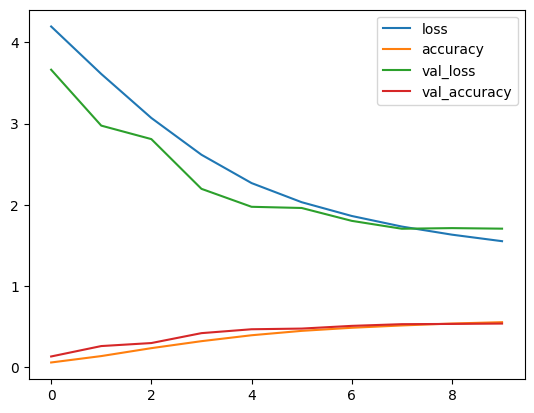

In [16]:
# Perte
plt.plot(r.history['loss'])

# Précision
plt.plot(r.history['sparse_categorical_accuracy'])

# Perte (validation)
plt.plot(r.history['val_loss'])

# Précision (validation)
plt.plot(r.history['val_sparse_categorical_accuracy'])

plt.legend(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
plt.show()

On constate que la précision augmente au fur et à mesure des epochs, et que la perte diminue. C'est un bon signe, cela signifie que notre modèle apprend bien.

Cependant, on constate aussi que la précision augmente de moins en moins au fur et à mesure des epochs, et que la perte diminue de moins en moins. Cela est normal, car plus le modèle apprend, plus il est difficile pour lui d'améliorer ses performances.

## Test du modèle

### Évaluation des performances

Maintenant que notre modèle est entraîné, nous allons évaluer ses performances grâce au dataset de test. On va donc utiliser la fonction `evaluate` pour évaluer le modèle sur les images de test.

In [22]:
test_loss, test_accuracy = model.evaluate(test_dataset_tf_preprocessed)

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 1.6928 - sparse_categorical_accuracy: 0.5461


C:\Users\tangu\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Avec 10 epochs, on obtient une précision supérieure à **50%**. C'est un bon score, mais on pourrait évidemment l'améliorer en augmentant le nombre d'epochs et la taille du dataset.

### Test interactif

Pour constater comment notre modèle se comporte sur des images de test, on va créer une fonction `test_model` qui permettra de prédire le label d'un certain nombre d'images aléatoires, et d'afficher les images avec leur vrai label ainsi que le label prédit.

In [17]:
def test_model(model, test_dataset, num_samples):
    """
    Utilise le `model` passé en paramètre pour prédire `num_samples` labels
    à partir du `test_dataset`.
    Affiche les images avec leur label et les prédictions associées.
    """

    # Récupération d'images aléatoirement
    indices = random.sample(range(len(test_dataset)), num_samples)
    sample_images = [test_dataset[i]["img"] for i in indices]
    sample_labels = [test_dataset[i]["fine_label"] for i in indices]

    # Pré-traitement des images récupérées
    sample_images_preprocessed = [preprocess_image(img, label)[0].numpy() for img, label in zip(sample_images, sample_labels)]
    sample_images_preprocessed = np.array(sample_images_preprocessed)

    # Prédiction des labels
    predictions = model.predict(sample_images_preprocessed)
    predicted_labels = np.argmax(predictions, axis=1)

    # Affichage des résultats
    plt.figure(figsize=(20, 20))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(sample_images[i])
        true_label = fine_labels_dict[sample_labels[i]]
        predicted_label = fine_labels_dict[predicted_labels[i]]
        plt.title(f'Réel: {true_label}\nPred: {predicted_label}')
        plt.axis('off')

    plt.show()

Utilisons maintenant la fonction, pour afficher et prédire les labels de 10 images :

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


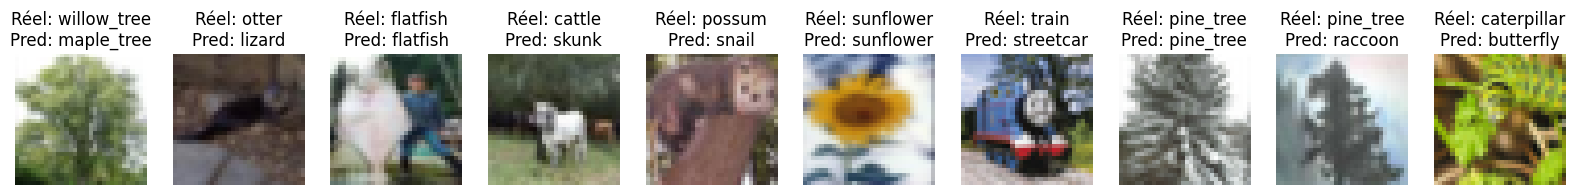

In [23]:
test_model(model, test_dataset, 10)

On constate que notre modèle parvient à prédire correctement la plupart des images. Cela signifie que notre modèle a bien appris, et qu'il est capable de généraliser sur des images qu'il n'a jamais vues.

De plus, on remarque que lorsque le modèle se trompe, il prédit tout de même des labels assez proches de la réalité. Il va correctement prédire un animal, mais se tromper sur l'espèce, par exemple. Même chose pour les plantes, les véhicules, etc. Si nous avions utilisé le dataset avec les `coarse labels`, le modèle aurait sûrement été plus précis, car les classes sont plus générales.

Certaines images sont difficiles à prédire, même pour un humain. C'est normal, car CIFAR-100 est un dataset difficile, avec des images de basse résolution et des classes très similaires.

## Sauvegarde du modèle

Sauvegardons le modèle pour pouvoir le réutiliser plus tard.

In [19]:
model.save('cifar100_model.keras')

## Chargement du modèle

Si vous n'avez pas pu entraîner le modèle, chargeons la version mise à disposition et testons-le.

In [20]:
loaded_model = tf.keras.models.load_model('cifar100_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


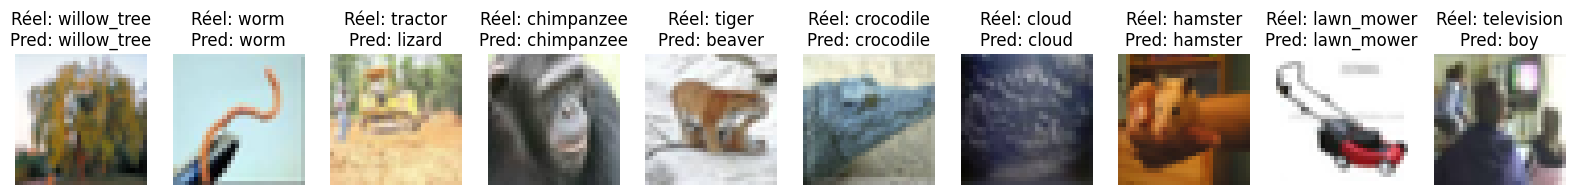

In [21]:
test_model(loaded_model, test_dataset, 10)

## Conclusion

Ma méthode pour reconnaître les images de CIFAR-100, un modèle CNN, est avantageuse car elle permet d'obtenir une bonne précision avec une **architecture simple**, pas énormément de **données**, et un temps d'entraînement **raisonnable**.

Évidemment, ce modèle n'est pas parfait, et il y a de nombreuses façons de l'améliorer. On pourrait par exemple :

- Utiliser un modèle plus complexe (plus de couches, plus de neurones)
- Augmenter le nombre d'epochs
- Augmenter la taille du dataset
- Expérimenter encore plus avec l'architecture du réseau de neurones afin de trouver la meilleure configuration possible

Je suis néanmoins très content de ce projet de deep learning. En montant jusqu'à **50 epochs** sur Google Colab, j'ai pu obtenir une précision de plus de **70%** sur le dataset de test, ce qui est un très bon score pour un tel modèle.

En comparaison, les modèles de deep learning sur [ImageNet](https://paperswithcode.com/sota/image-classification-on-imagenet) atteignent des précisions de **90%** et plus, mais ils sont entraînés sur bien plus d'images de meilleure qualité avec des architectures bien plus complexes (*2 milliards* de paramètres pour certains modèles, comparé à *4 millions* pour le mien).

Je suis donc très satisfait de ce projet, et j'ai hâte de continuer à explorer le monde du deep learning et de l'intelligence artificielle.